In [30]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from hamiltonian import hamiltonian_para
from qannealing import annealing
from data_score import Generate_Data, score
import numpy as np
import heapq
from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt

In [87]:
n = 2
# D = Generate_Data(n)

C, h, J = hamiltonian_para(n, m, D, delta_max, \
                           delta_cons, delta_trans)
print(h,J)

Before spin transformation: 120*d[0, 1]*r[0, 0] + 200*d[0, 1]*y[1, 0] + 400*d[0, 1]*y[1, 1] - 129.376841974903*d[0, 1] - 120*d[1, 0]*r[0, 0] + 200*d[1, 0]*y[0, 0] + 400*d[1, 0]*y[0, 1] - 9.74063940584657*d[1, 0] + 400*y[0, 0]*y[0, 1] - 100*y[0, 0] + 400*y[1, 0]*y[1, 1] - 100*y[1, 0] + 448.694204999984
Brute force results: {'0100110': 218.95356559413779, '0001001': 219.3173630250816, '0101000': 248.69420499998438, '0101100': 248.69420499998438, '0000011': 309.57672361923505}
[115.31157901 115.1296803    0.         100.         200.
 100.         200.        ] [[  0.   0.  30.   0.   0.  50. 100.]
 [  0.   0. -30.  50. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.]
 [  0.   0.   0.   0.   0.   0.   0.]]


In [90]:
C, h, J = hamiltonian_para(n, m, D, delta_max, \
                           delta_cons, delta_trans)
print(h,J)

Before spin transformation: 120*d[0, 1]*r[0, 0] + 200*d[0, 1]*y[1, 0] + 400*d[0, 1]*y[1, 1] - 129.376841974903*d[0, 1] - 120*d[1, 0]*r[0, 0] + 200*d[1, 0]*y[0, 0] + 400*d[1, 0]*y[0, 1] - 9.74063940584657*d[1, 0] + 400*y[0, 0]*y[0, 1] - 100*y[0, 0] + 400*y[1, 0]*y[1, 1] - 100*y[1, 0] + 448.694204999984
Brute force results: {'0100110': 218.95356559413779, '0001001': 219.3173630250816, '0101000': 248.69420499998438, '0101100': 248.69420499998438, '0000011': 309.57672361923505}
[115.31157901 115.1296803    0.         100.         200.
 100.         200.        ] [[  0.   0.  30.   0.   0.  50. 100.]
 [  0.   0. -30.  50. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.]
 [  0.   0.   0.   0.   0.   0.   0.]]


[1, 0] [0] [1, 0, 0, 0] True True True


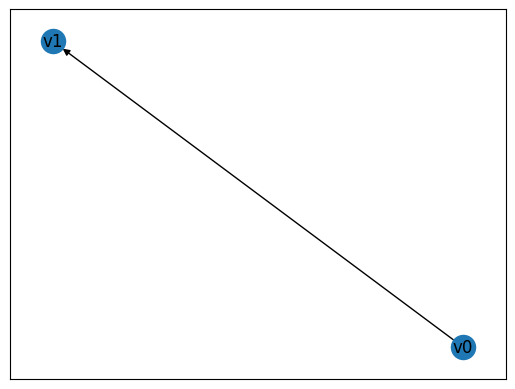

In [113]:
# experiment for n = 2
def QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 100, delta_cons = 120, delta_trans = 100):
    D = Generate_Data(n)

    C, h, J = hamiltonian_para(n, m, D, delta_max, \
                           delta_cons, delta_trans)

    circ = annealing(n, M, h, J, T, lamda)
    simulator = AerSimulator()
    compiled_circuit = transpile(circ, simulator)
    job = simulator.run(compiled_circuit, shots = 3000)
    res = job.result()
    counts = res.get_counts(compiled_circuit)
    return counts

def res_extractor(res, n, m):
    if len(res) != int(n*(n-1)*3/2 + 2*n):
        return None
    
    # Notice that '0' in res means positive flip +1 and is correspond to 1 as variables.

    res = list(res)[::-1]
    res = [1 - int(tmp) for tmp in res]

    d = res[:int(n*(n-1))]
    r = res[int(n*(n-1)): int(n*(n-1)*3/2)]
    y = res[int(n*(n-1)*3/2):]

    is_cons = True 
        # no two nodes are mutual connected and r_ij = 0 iff x_i > x_j in topo. order
    is_dag = True
        # check r_ij s.t. x_i > x_k > x_j > x_i
    is_legal = True 
        # having at most m indgree and y_i + d_i = m

    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i, desc='v'+str(i))
    edge_list = []
    
    for i in range(n-1):
        for j in range(i+1,n):
            r_ij = int(i*(n-1) - i*(i+1)/2 + j - 1)
            d_ij = n*i + j - 1
            d_ji = i + n*j - 1
            if d[d_ij] == 1 and d[d_ji] == 1:
                is_cons = False
            elif d[d_ij] == 1:
                if r[r_ij] == 1:
                    is_cons = False
                edge_list.append((i,j))
            elif d[d_ji] == 1:
                if r[r_ij] == 0:
                    is_cons = False
                edge_list.append((j,i))

    G.add_edges_from(edge_list)

    for i in range(n-2):
        for j in range(i+1, n-1):
            idx_ij = int(i*(n-1) - i*(i+1)/2 + j - 1)
            for k in range(j+1, n):
                idx_ik = int(i*(n-1) - i*(i+1)/2 + k - 1)
                idx_jk = int(j*(n-1) - j*(j+1)/2 + k - 1)
                
                circ = r[idx_ik] + r[idx_ij] * r[idx_jk] - r[idx_ij]*r[idx_ik] - r[idx_jk]*r[idx_ik]
                
                if circ > 0:
                    is_dag = False
                    break
    
    for i in range(n):
        i_parent_num = 0
        for x in edge_list:
            if x[1] == i:
                i_parent_num += 1
        slack = 2*y[2*i + 1] + y[2*i]
        if i_parent_num + slack != m:
            is_legal = False
            break
    
    return d, r, y, G, \
        is_cons, is_dag, is_legal

def draw_graph(G):
    pos = nx.spring_layout(G)
    node_labels = nx.get_node_attributes(G, 'desc')
    nx.draw_networkx(G, pos = pos, with_labels=None)
    nx.draw_networkx_labels(G, pos, node_labels)

tmp = '0100110'
tmp = '1110110'
n = 2
m = 1
d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
print(d, r, y, is_cons, is_dag, is_legal)
draw_graph(G)


In [111]:
n = 2
m = 1

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(tmp, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 120, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(tmp, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 120, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(tmp, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 120)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(tmp, is_cons, is_dag, is_legal)


Before spin transformation: 90*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 133.121339339251*d[0, 1] - 90*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 43.4213500625891*d[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 433.049599057739
Brute force results: {'0100110': 209.62824899514982, '0001001': 209.92825971848822, '0101000': 253.04959905773887, '0101100': 253.04959905773887, '0000011': 256.50690965589916}
1110110 True True True
1011001 True True True
1010111 True True True
1010011 True True True
1111100 False True False
Before spin transformation: 90*d[0, 1]*r[0, 0] + 240*d[0, 1]*y[1, 0] + 480*d[0, 1]*y[1, 1] - 155.318323823116*d[0, 1] - 90*d[1, 0]*r[0, 0] + 240*d[1, 0]*y[0, 0] + 480*d[1, 0]*y[0, 1] - 65.7258700974277*d[1, 0] + 480*y[0, 0]*y[0, 1] - 120*y[0, 0] + 480*y[1, 0]*y[1, 1] - 120*y[1, 0] + 484.151273376666
Brute force results: {'0100110': 208.42540327923786, '0001001': 208.83294955354984, '0101000': 244.1512733

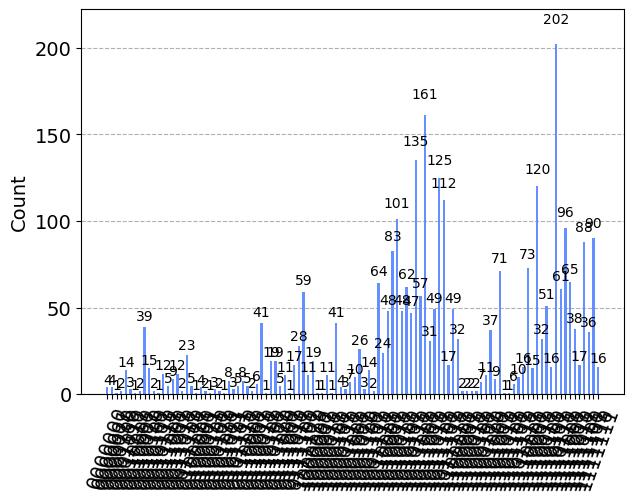

In [114]:
# from qiskit.visualization import array_to_latex, plot_histogram
# plot_histogram(counts)